In [29]:
!pip install xarray
!pip install bottleneck
!pip install keras

    100% |████████████████████████████████| 317kB 23.7MB/s 
    100% |████████████████████████████████| 61kB 25.8MB/s 
    100% |████████████████████████████████| 61kB 14.5MB/s 


In [3]:
import numpy as np
import pandas as pd
import xarray as xr
import os
import io
from typing import *

## Raw data download helper scripts

Helper code for automating download of raw data directly from KNMI. Data must have been recently generated and published on KNMI server.

In [4]:
import wget

N_models = 65
tasmin_uri_base = 'https://climexp.knmi.nl/data/icmip5_tasmin_Amon_ens_rcp26_-125--65E_25-50N_n_'
tasmax_uri_base = 'https://climexp.knmi.nl/data/icmip5_tasmax_Amon_ens_rcp26_-125--65E_25-50N_n_'
pr_uri_base = 'https://climexp.knmi.nl/data/icmip5_pr_Amon_ens_rcp26_-125--65E_25-50N_n_'
evspspl_uri_base = 'https://climexp.knmi.nl/data/icmip5_evspsbl_Amon_ens_rcp26_-125--65E_25-50N_n_'
pme_uri_base = 'https://climexp.knmi.nl/data/icmip5_pme_Amon_ens_rcp26_-125--65E_25-50N_n_'
hurs_uri_base = 'https://climexp.knmi.nl/data/icmip5_hurs_Amon_ens_rcp26_-125--65E_25-50N_n_'
psl_uri_base = 'https://climexp.knmi.nl/data/icmip5_psl_Amon_ens_rcp26_-125--65E_25-50N_n_'
for i in range(63, N_models):
    uri = '{}{:03d}.dat'.format(psl_uri_base, i)
    print('Downloading model {}/{} from {}'.format(i+1, N_models, uri))
    wget.download(uri)

ModuleNotFoundError: No module named 'wget'

## Preprocessing for raw data files

1. Parse and save raw data into per variable datasets

In [5]:
raw_data_dir = 'raw_data'
var_names = ['tas','tasmin','tasmax','pr','pme','evspsbl']
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

In [6]:
import os.path

# create data/ directory
if not os.path.exists('data'):
    os.mkdir('data')

def parse_model_file(filename: str) -> pd.DataFrame:
    def parse_header(lines: List[str]) -> Tuple[Dict[str, str], int]:
        metadata = dict()
        for (i, line) in enumerate(lines):
            # stop at end of header
            if not line.startswith('#'):
                return metadata, i
            # skip header lines that not in key-value format
            if not '::' in line:
                continue
            kv = line.replace('#', '').split('::')
            assert len(kv) == 2
            metadata[kv[0].strip()] = kv[1].strip()
    with open(filename) as f:
        lines = f.readlines()
        metadata, i = parse_header(lines)
        csv_str = "".join(lines[i:])
        df = pd.read_csv(io.StringIO(csv_str), delim_whitespace=True, header=None)
        years = df[0]
        df = df.drop(columns=[0])
        name = '{}_{}'.format(metadata['model_id'], metadata['realization'])
        xdarr = xr.DataArray(df, coords=[years, months], dims=['years', 'months'], attrs=metadata, name=name)
        return xdarr

In [ ]:
for var in var_names:
    dirname = './{}/{}'.format(raw_data_dir, var)
    models = dict()
    for file in filter(lambda f: not f.startswith('.'), os.listdir(dirname)):
        xdarr = parse_model_file('{}/{}'.format(dirname, file))
        models[xdarr.name] = xdarr
    ds = xr.Dataset(models)
    ds.to_netcdf("./data/{}.nc".format(var))

2. Collect and organize raw data to construct per-model datasets

In [7]:
# Utility functions

def center_monthly_means(xdarr: xr.DataArray) -> xr.DataArray:
    attrs = xdarr.attrs
    means = xdarr.mean(dim='years', keep_attrs=True)
    xdarr = xdarr - means
    xdarr.attrs = attrs
    return xdarr

def flatten_months(xdarr: xr.DataArray) -> xr.DataArray:
    d0,d1 = xdarr.shape
    xdarr = xdarr.stack(time=('years','months'))
    assert(len(xdarr.shape) == 1)
    assert(xdarr.shape[0] == d0*d1)
    return xdarr

In [11]:
var_datasets = dict()
for var in var_names:
    xds = xr.open_dataset('data/{}.nc'.format(var))
    var_datasets[var] = xds
    
common_models = set()
for var, ds in var_datasets.items():
    if len(common_models) == 0:
        common_models |= ds.data_vars.keys()
    else:
        common_models &= ds.data_vars.keys()
var_data = dict()
for var, ds in var_datasets.items():
    xs = []
    model_names = []
    print('processing model data for {}'.format(var))
    for model in sorted(filter(lambda m: m in common_models, ds.data_vars.keys())):
        xdarr = ds.data_vars[model]
        # fill NaNs
        xdarr = xdarr.ffill(dim='years')
        xdarr = xdarr.bfill(dim='years')
        xdarr = center_monthly_means(xdarr)
        xdarr = flatten_months(xdarr)
        xs.append(xdarr)
        model_names.append(model)
    print('building data array for {}'.format(var))
    var_dr = xr.DataArray(xs, [('models', model_names),('time', xs[0].indexes['time'])])
    var_data[var] = var_dr

print('building dataset for all variables')
model_time_var_ds = xr.Dataset(var_data)
print(model_time_var_ds)
model_time_var_ds = model_time_var_ds.reset_index('time')
print(model_time_var_ds)
model_time_var_ds.to_netcdf('./data/{}.nc'.format('models_all_vars_vs_time'))

processing model data for tas
building data array for tas
processing model data for tasmin
building data array for tasmin
processing model data for tasmax
building data array for tasmax
processing model data for pr
building data array for pr
processing model data for pme
building data array for pme
processing model data for evspsbl
building data array for evspsbl
building dataset for all variables
<xarray.Dataset>
Dimensions:  (models: 40, time: 2880)
Coordinates:
  * models   (models) <U16 'CCSM4_1' 'CCSM4_2' ... 'MRI-CGCM3_1' 'NorESM1-M_1'
  * time     (time) MultiIndex
  - years    (time) int64 1861 1861 1861 1861 1861 ... 1863 1863 1863 1863 1863
  - months   (time) object 'Jan' 'Feb' 'Mar' 'Apr' ... 'Mar' 'Apr' 'May' 'Jun'
Data variables:
    tas      (models, time) float64 -1.232 -0.9981 -0.3392 ... 1.091 1.176
    tasmin   (models, time) float64 -0.8222 -3.135 -0.5128 ... 1.486 0.5544
    tasmax   (models, time) float64 -0.5729 -2.731 -0.5294 ... 1.633 -0.1004
    pr       (mode

In [22]:
from sklearn.decomposition import PCA
from sklearn.manifold import SpectralEmbedding, TSNE
import matplotlib.pyplot as plt

(40,)


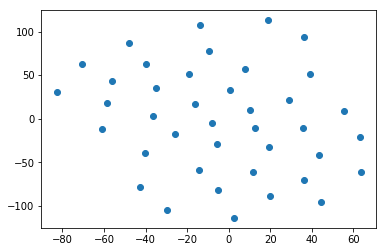

In [28]:
tas = model_time_var_ds['tas']
X_tas = tas.values

tsne = TSNE()
X_tas_tsne = tsne.fit_transform(X_tas)
print(X_tas_tsne[:,0].shape)
plt.scatter(X_tas_tsne[:,0], X_tas_tsne[:,1])
plt.show()